In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  0
[]


'2.2.0'

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Loading OOD datasets

In [14]:
with open("train_scores_100_0.p", "rb") as f:
    train_scores = pickle.load(f)
train_scores.shape

(50000, 10)

In [15]:
with open("scores_ckpt-9.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [16]:
inlier_scores = score_dict["cifar"]
outlier_scores = [score_dict["celeba"], score_dict["svhn"]]

In [17]:
with open("ood_scores_ckpt-9.p", "rb") as f:
    ood_dict = pickle.load(f)
outlier_scores.extend([x for x in ood_dict.values()])

In [18]:
ood_names = list(score_dict.keys())[1:] + list(ood_dict.keys())
ood_names, len(outlier_scores)

(['celeba',
  'svhn',
  'LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform'],
 9)

## Calculating Scores

In [9]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN", 'LSUN','LSUN_resize',
                   'Imagenet','Imagenet_resize','iSUN',"Gaussian", "Uniform"])
COLORS = sns.color_palette("bright")

In [41]:
cifar_score = inlier_scores[:, -1]
ood_scores = [ood[:,-1] for ood in outlier_scores]

In [43]:
evaluate_model(train_scores[:,-1], cifar_score, ood_scores, labels=LABELS)

In [39]:
rows = 1
fig, axs = plt.subplots(rows, 1, figsize=(12,rows*4))
axs = np.array(axs).reshape(-1) # Makes axs into list even if row num is 1
colors = sns.color_palette("bright") + sns.color_palette("dark")
kwargs={"kde":True}

sns.distplot(cifar_score, color=colors[0], label="CIFAR", ax=axs[0], **kwargs)
sns.distplot(svhn_score, color=colors[1], label="SVHN", ax=axs[0], **kwargs)
plt.legend()

In [40]:
ood_metrics(cifar_score, svhn_score, names=(LABELS[1], "SVHN"),plot=True, verbose=True)

CIFAR vs SVHN
----------------
ROC-AUC: 0.9984
PR-AUC (In/Out): 0.9984 / 0.9985
FPR (95% TPR) Prec: 0.61%


{'roc_auc': 0.99843063,
 'fpr_tpr95': 0.0061,
 'fpr_tpr80': 0.0006,
 'pr_auc_in': 0.9984074256044351,
 'pr_auc_out': 0.9985097384506401,
 'ap': 0.998407507851881}

## Train Data = L2-norm(Pixel Scores)

In [42]:
X_train, X_test =  train_scores.copy(), inlier_scores.copy()

## GMM

In [20]:
%%time
best_gmm_clf = train_gmm(X_train, verbose=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.6min finished


Best: 2.537521 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
2.104549 (0.049816) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.345506 (0.048818) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.433299 (0.047039) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.453240 (0.046501) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.490784 (0.040617) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.508760 (0.044491) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.519493 (0.045328) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.528924 (0.043835) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.533912 (0.041201) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.537521 (0.043129) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
CPU times

In [21]:
print("---Likelihoods---")
print("Training: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{}: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))

for name, ood in zip(LABELS[2:], outlier_scores):
    print("{}: {:.3f}".format(name, best_gmm_clf.score(ood)))

---Likelihoods---
Training: 2.571
CIFAR: 2.427
CelebA: 0.746
SVHN: -4.146
LSUN: -1104.889
LSUN_resize: -598.525
Imagenet: -636.827
Imagenet_resize: -784.712
iSUN: -647.582
Gaussian: -397.058
Uniform: -362.290


In [22]:
%%time
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
ood_scores = [best_gmm_clf.score_samples(ood) for ood in outlier_scores]

CPU times: user 12 s, sys: 23.8 s, total: 35.8 s
Wall time: 778 ms


# OOD Evaluation

In [23]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.6770
PR-AUC (In/Out): 0.6383 / 0.6830
FPR (95% TPR) Prec: 80.94%

CIFAR vs SVHN
----------------
ROC-AUC: 0.9590
PR-AUC (In/Out): 0.9251 / 0.9711
FPR (95% TPR) Prec: 10.56%

CIFAR vs LSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

CIFAR vs LSUN_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

CIFAR vs Imagenet
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

CIFAR vs iSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%



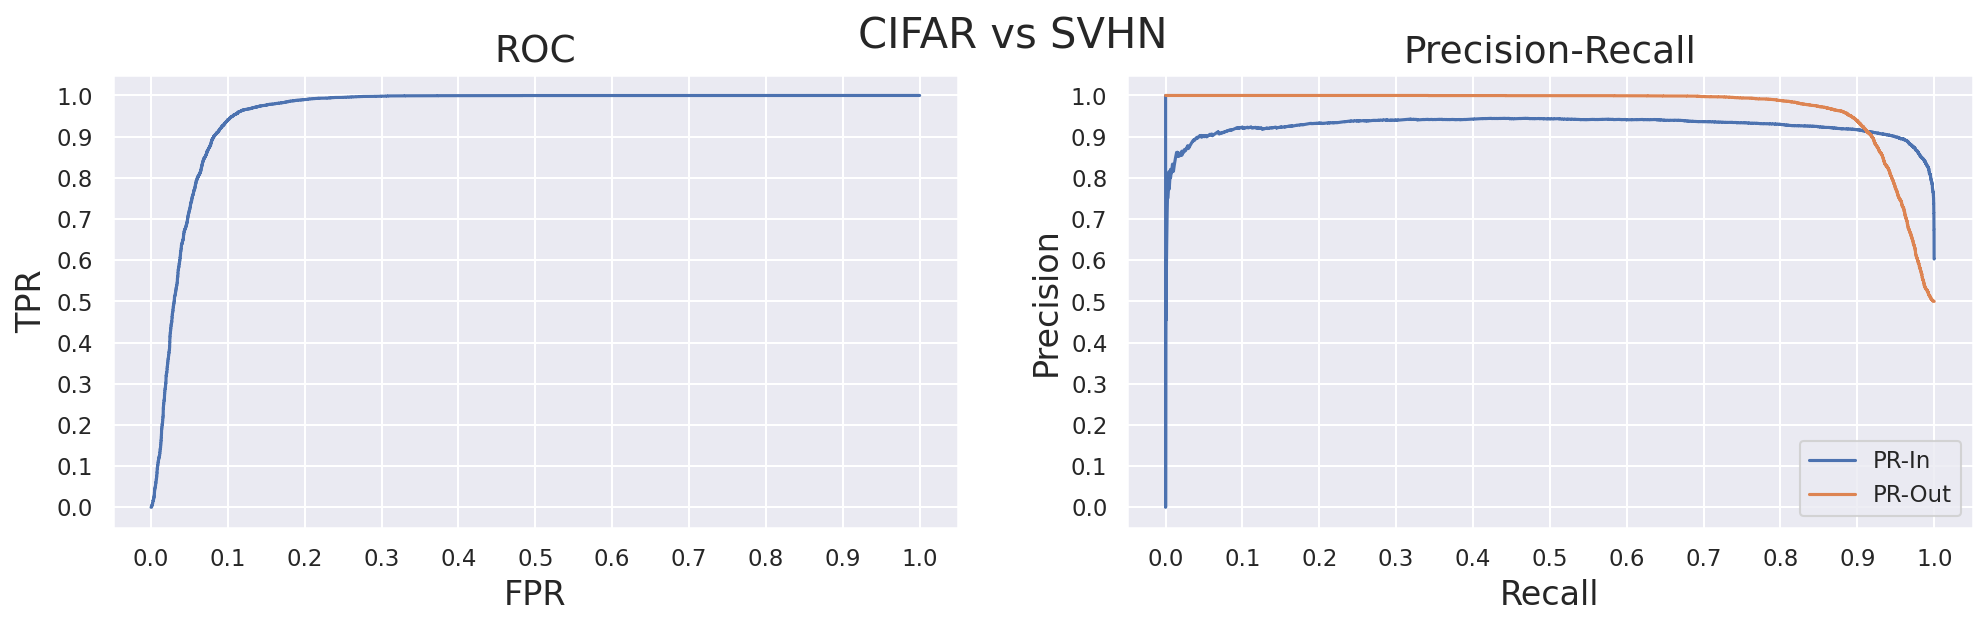

CIFAR vs SVHN
----------------
ROC-AUC: 0.9590
PR-AUC (In/Out): 0.9251 / 0.9711
FPR (95% TPR) Prec: 10.56%


{'roc_auc': 0.9589635600000002,
 'fpr_tpr95': 0.1056,
 'fpr_tpr80': 0.0604,
 'pr_auc_in': 0.9251245314057921,
 'pr_auc_out': 0.9711388846390376,
 'ap': 0.9252052261784804}

In [24]:
ood_metrics(-test_score, -ood_scores[1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

# Validation Check

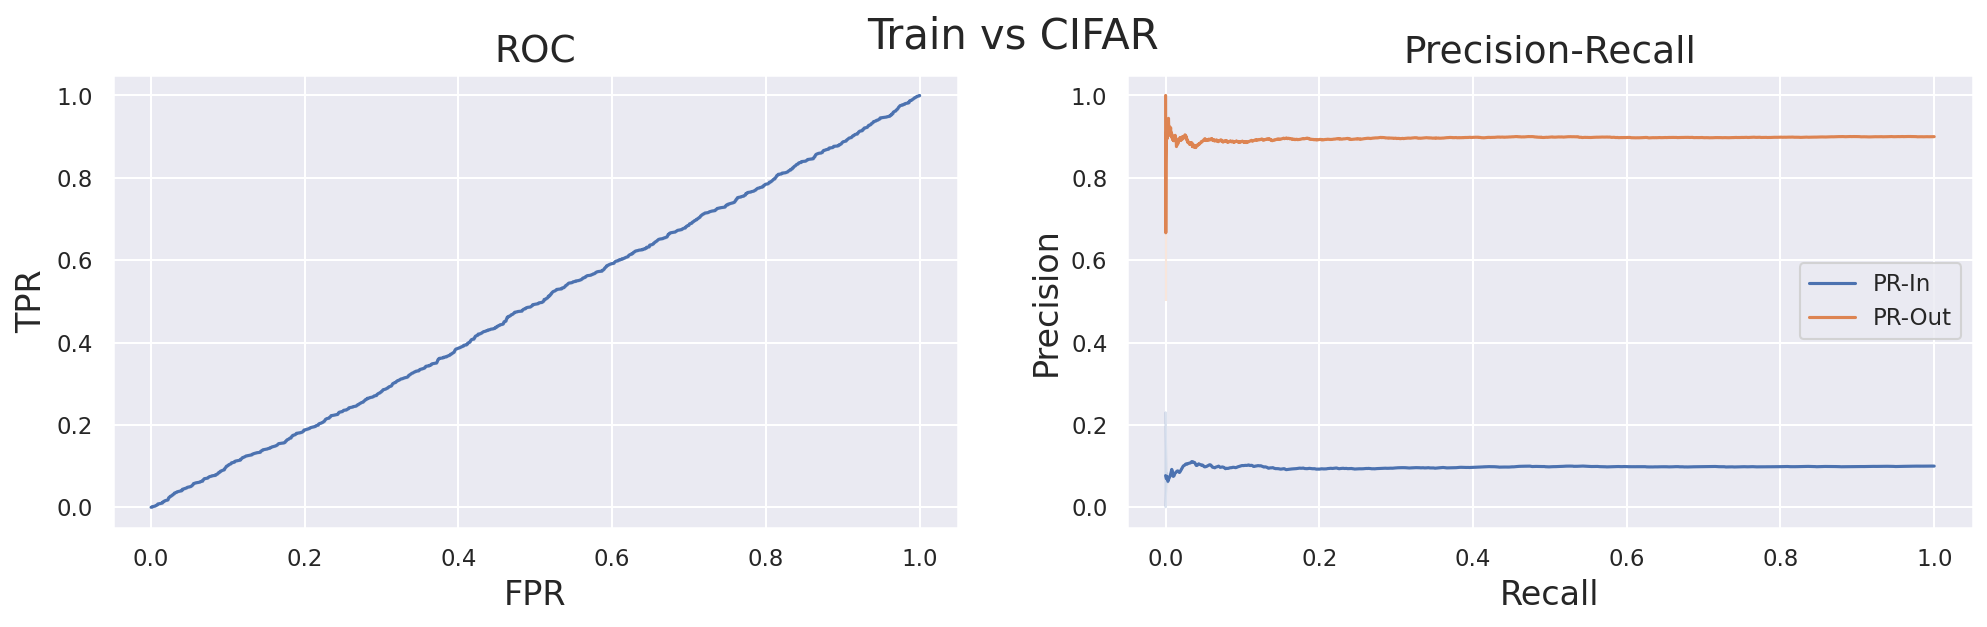

Train vs CIFAR
----------------
ROC-AUC: 0.4902
PR-AUC (In/Out): 0.0975 / 0.8968
FPR (95% TPR) Prec: 0.9580


{'roc_auc': 0.49024355555555554,
 'fpr_tpr95': 0.958,
 'fpr_tpr80': 0.8121111111111111,
 'pr_auc_in': 0.09748255842113301,
 'pr_auc_out': 0.8967675385527123,
 'ap': 0.0978025183350293}

In [22]:
ood_metrics(-train_score, -test_score, names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

### Flow Models

In [25]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [26]:
# X_train = 
X_train.shape

(50000, 10)

In [85]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[64, 64], activation="elu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob)

batch_size = 128

In [100]:
## Starting from 1k epochs

In [ ]:
%%time
epochs = 10000
history = model.fit(
    x=X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Epoch 1/10000
390/390 [==============================] - 1s 3ms/step - loss: 7.5578
Epoch 2/10000
390/390 [==============================] - 1s 3ms/step - loss: 7.5560
Epoch 3/10000
390/390 [==============================] - 1s 3ms/step - loss: 7.5499
Epoch 4/10000
390/390 [==============================] - 1s 3ms/step - loss: 7.5496
Epoch 5/10000
390/390 [==============================] - 1s 3ms/step - loss: 7.5513
Epoch 6/10000
390/390 [==============================] - 1s 3ms/step - loss: 7.5418
Epoch 7/10000
390/390 [==============================] - 1s 2ms/step - loss: 7.5444
Epoch 8/10000
390/390 [==============================] - 1s 2ms/step - loss: 7.5344
Epoch 9/10000
390/390 [==============================] - 1s 3ms/step - loss: 7.5472
Epoch 10/10000
390/390 [==============================] - 1s 2ms/step - loss: 7.5371
Epoch 11/10000
390/390 [==============================] - 1s 2ms/step - loss: 7.5326
Epoch 12/10000
390/390 [==============================] - 1s 2ms/step - lo

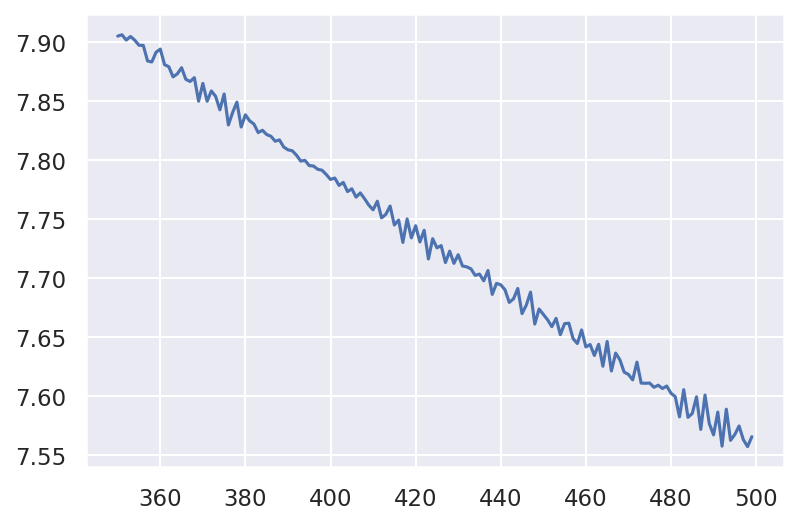

In [93]:
start_idx=350
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

In [97]:
print("NaN", "Inf")
for x in ood_scores:
    print(np.isnan(x).any(), np.isinf(x).any() )

NaN Inf
False False
False False
False False
False False
False False
False False
False False
False False
False False


In [98]:
%%time
train_score = distribution.log_prob(X_train, dtype=np.float32).numpy()
test_score = distribution.log_prob(X_test, dtype=np.float32).numpy()
ood_scores = [distribution.log_prob(ood, dtype=np.float32).numpy() for ood in outlier_scores]

CPU times: user 1.55 s, sys: 1.02 s, total: 2.57 s
Wall time: 285 ms


CIFAR vs CelebA
----------------
ROC-AUC: 58.8900
PR-AUC (In/Out): 55.9874 / 60.0505
FPR (95% TPR): 87.63%
Detection Error: 43.38%

CIFAR vs SVHN
----------------
ROC-AUC: 97.6971
PR-AUC (In/Out): 96.0144 / 98.3494
FPR (95% TPR): 6.75%
Detection Error: 5.59%

CIFAR vs LSUN
----------------
ROC-AUC: 99.9994
PR-AUC (In/Out): 99.9994 / 99.9994
FPR (95% TPR): 0.00%
Detection Error: 0.04%

CIFAR vs LSUN_resize
----------------
ROC-AUC: 99.9992
PR-AUC (In/Out): 99.9993 / 99.9992
FPR (95% TPR): 0.00%
Detection Error: 0.10%

CIFAR vs Imagenet
----------------
ROC-AUC: 99.9995
PR-AUC (In/Out): 99.9995 / 99.9995
FPR (95% TPR): 0.00%
Detection Error: 0.09%

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 99.9999
PR-AUC (In/Out): 99.9999 / 99.9999
FPR (95% TPR): 0.00%
Detection Error: 0.05%

CIFAR vs iSUN
----------------
ROC-AUC: 99.9993
PR-AUC (In/Out): 99.9992 / 99.9994
FPR (95% TPR): 0.00%
Detection Error: 0.06%

CIFAR vs Gaussian
----------------
ROC-AUC: 100.0000
PR-AUC (In/Out): 100.0000

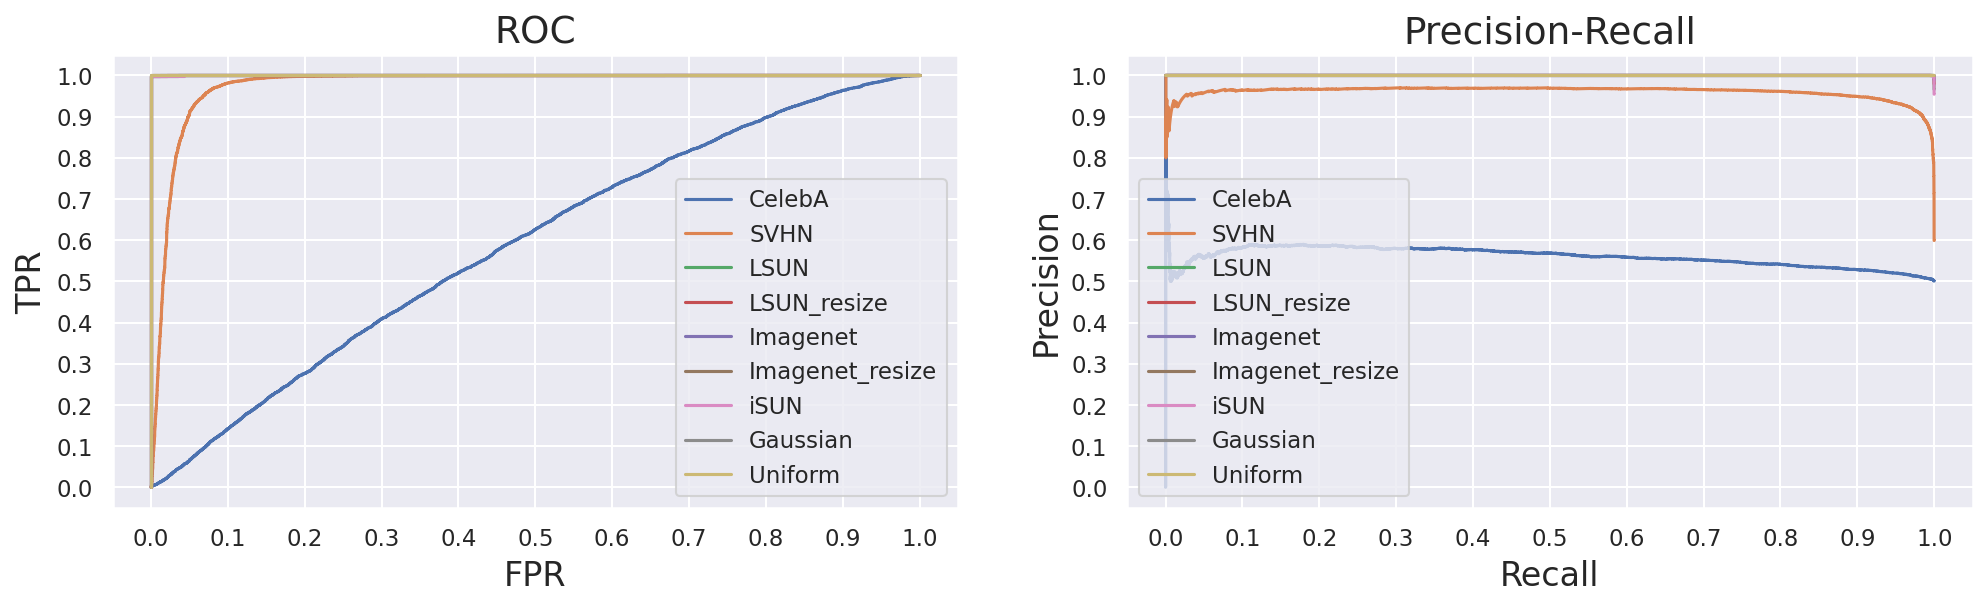

In [99]:
fig, axs = plt.subplots(1,2, figsize=(16,4))

for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()
    plot_curves(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]), figure=(fig, axs))

plt.show()

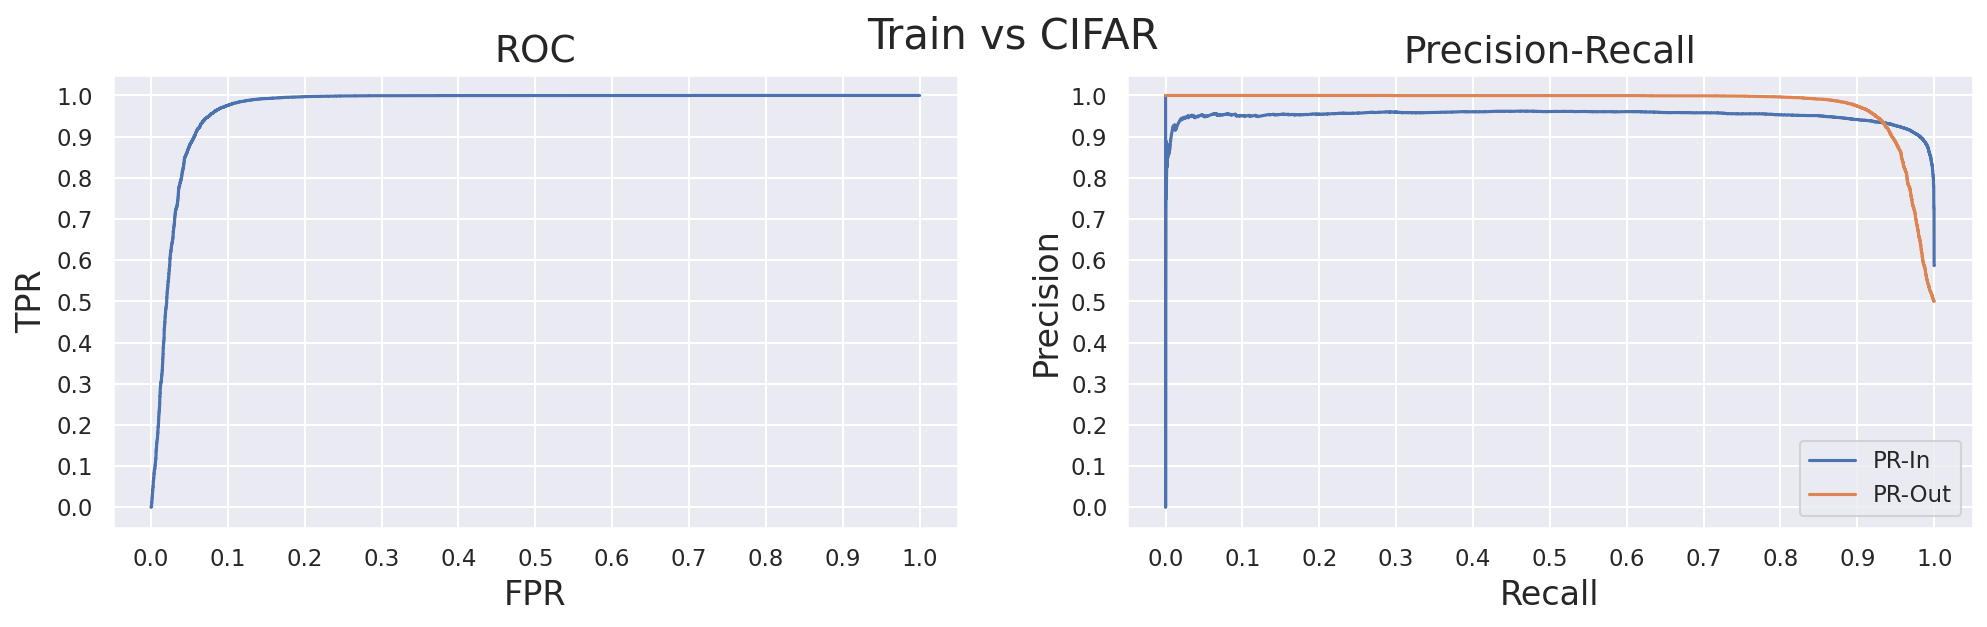

Train vs CIFAR
----------------
ROC-AUC: 0.9726
PR-AUC (In/Out): 0.9512 / 0.9808
FPR (95% TPR) Prec: 7.50%


{'roc_auc': 0.9725663,
 'fpr_tpr95': 0.075,
 'fpr_tpr80': 0.0395,
 'pr_auc_in': 0.9511674718997571,
 'pr_auc_out': 0.9807523485394273,
 'ap': 0.9512386438671567}

In [61]:
ood_metrics(-test_score, -ood_scores[1], names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

## CIFAR 10.1 Train

In [25]:
with open("cifar101_scores_ckpt-20.p", "rb") as f:
    cifar101_scores = pickle.load(f).numpy()
cifar101_scores.shape

(2000, 10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    6.5s finished


Best: 1.044107 using {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
---------------------------------------------------------------------------
0.911419 (0.165316) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
1.044107 (0.186802) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
1.035158 (0.163404) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
1.031568 (0.201130) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
0.973064 (0.178820) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
0.904938 (0.243008) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
0.773552 (0.202081) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
0.724550 (0.173075) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
0.529639 (0.198457) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
0.533186 (0.216133) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
CPU times:

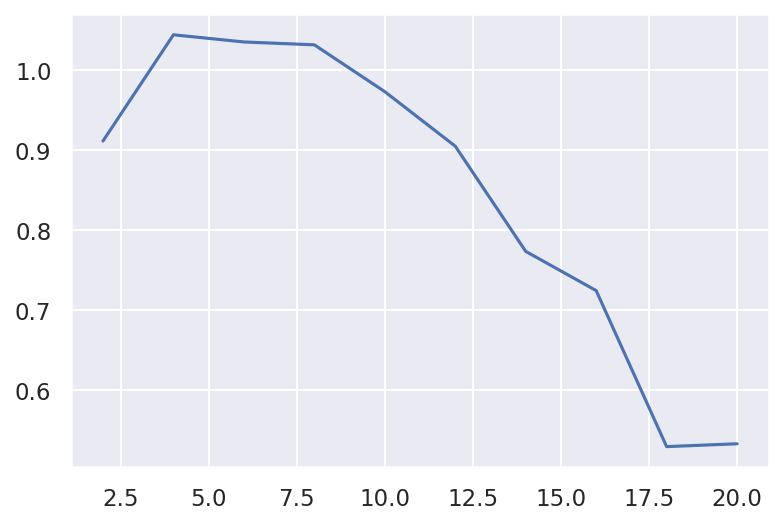

In [26]:
%%time
alt_gmm_clf = train_gmm(cifar101_scores, verbose=True)

In [36]:
print("---Likelihoods---")
print("Training: {:.3f}".format(alt_gmm_clf.score(cifar101_scores)))
print("{}: {:.3f}".format(LABELS[1], alt_gmm_clf.score(inlier_scores)))

for name, ood in zip(LABELS[2:], outlier_scores):
    print("{}: {:.3f}".format(name, alt_gmm_clf.score(ood)))

---Likelihoods---
Training: 1.249
CIFAR: 1.200
CelebA: -1.049
SVHN: -6.498
LSUN: -1167.097
LSUN_resize: -551.759
Imagenet: -641.380
Imagenet_resize: -728.180
iSUN: -618.080
Gaussian: -956.259
Uniform: -604.097


In [28]:
%%time
train_score = alt_gmm_clf.score_samples(X_train)
test_score = alt_gmm_clf.score_samples(inlier_scores)
ood_scores = [alt_gmm_clf.score_samples(ood) for ood in outlier_scores]

CPU times: user 2.99 s, sys: 3.86 s, total: 6.85 s
Wall time: 148 ms


### OOD Evaluation

In [30]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.7101
PR-AUC (In/Out): 0.6753 / 0.7162
FPR (95% TPR) Prec: 0.7605

CIFAR vs SVHN
----------------
ROC-AUC: 0.9598
PR-AUC (In/Out): 0.9326 / 0.9693
FPR (95% TPR) Prec: 0.1297

CIFAR vs LSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs LSUN_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Imagenet
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs iSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.000

### Validation Check

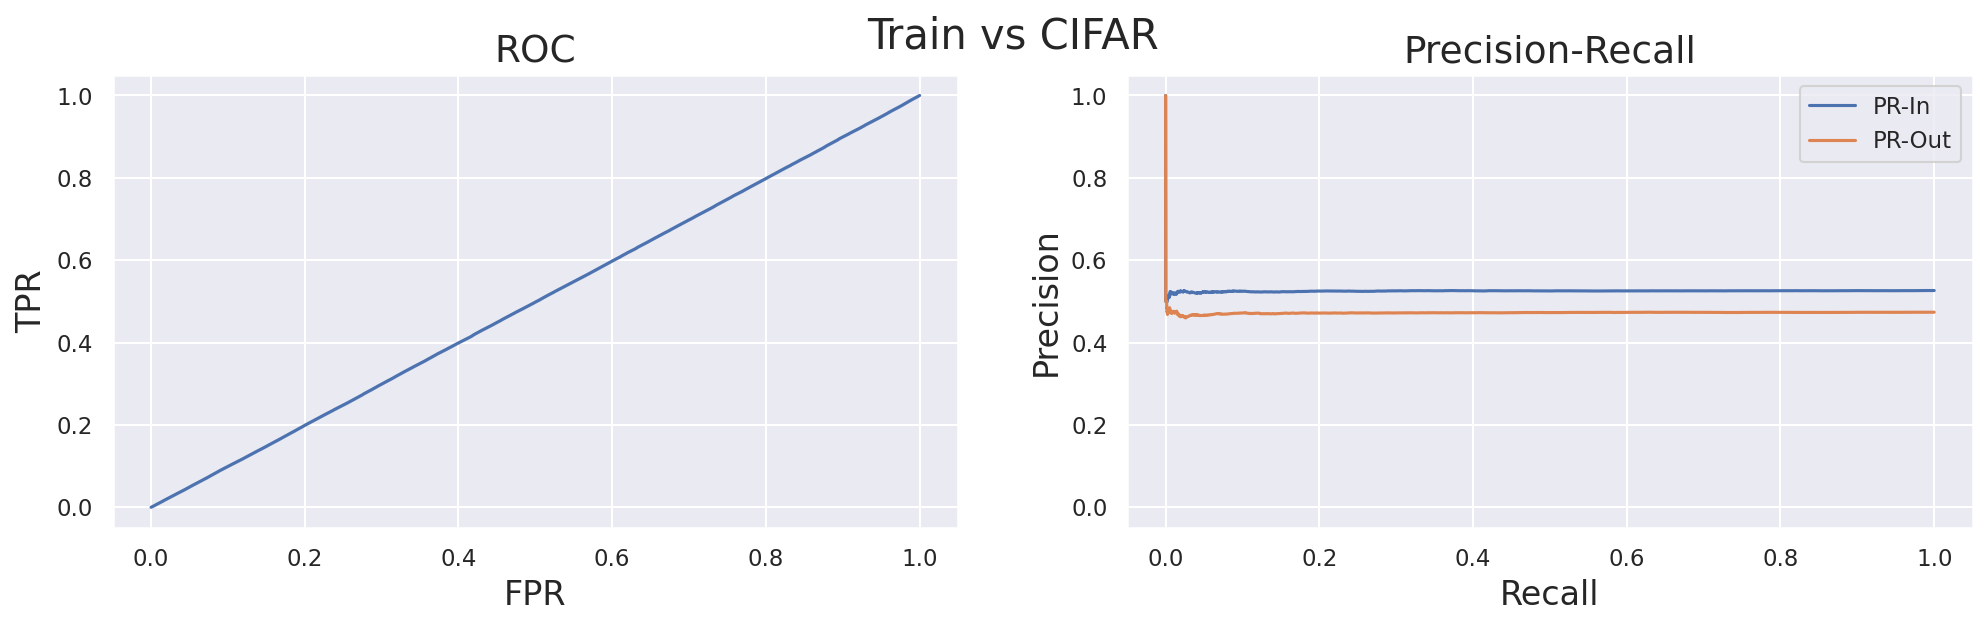

Train vs CIFAR
----------------
ROC-AUC: 0.4986
PR-AUC (In/Out): 0.5251 / 0.4724
FPR (95% TPR) Prec: 0.9504


{'roc_auc': 0.4986296777777778,
 'fpr_tpr95': 0.9504444444444444,
 'fpr_tpr80': 0.8016666666666666,
 'pr_auc_in': 0.525078059896663,
 'pr_auc_out': 0.47238386744133,
 'ap': 0.5250543756861367}

In [31]:
ood_metrics(-train_score, -test_score, names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

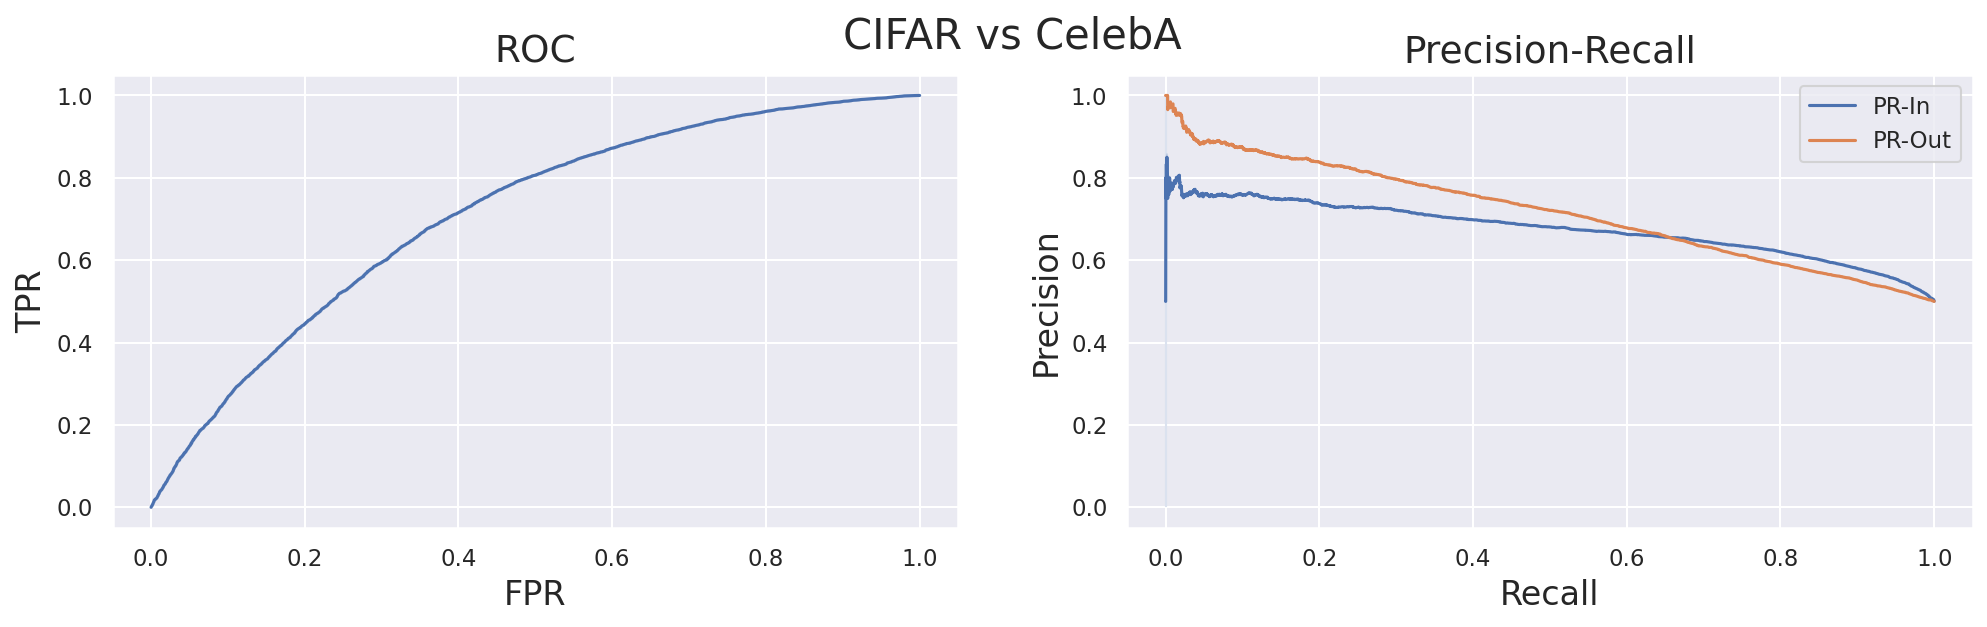

CIFAR vs CelebA
----------------
ROC-AUC: 0.7101
PR-AUC (In/Out): 0.6753 / 0.7162
FPR (95% TPR) Prec: 0.7605


{'roc_auc': 0.71006097,
 'fpr_tpr95': 0.7605,
 'fpr_tpr80': 0.4898,
 'pr_auc_in': 0.6753317279123834,
 'pr_auc_out': 0.71622341698213,
 'ap': 0.6754424285388184}

In [32]:
ood_metrics(-test_score, -ood_scores[0], names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

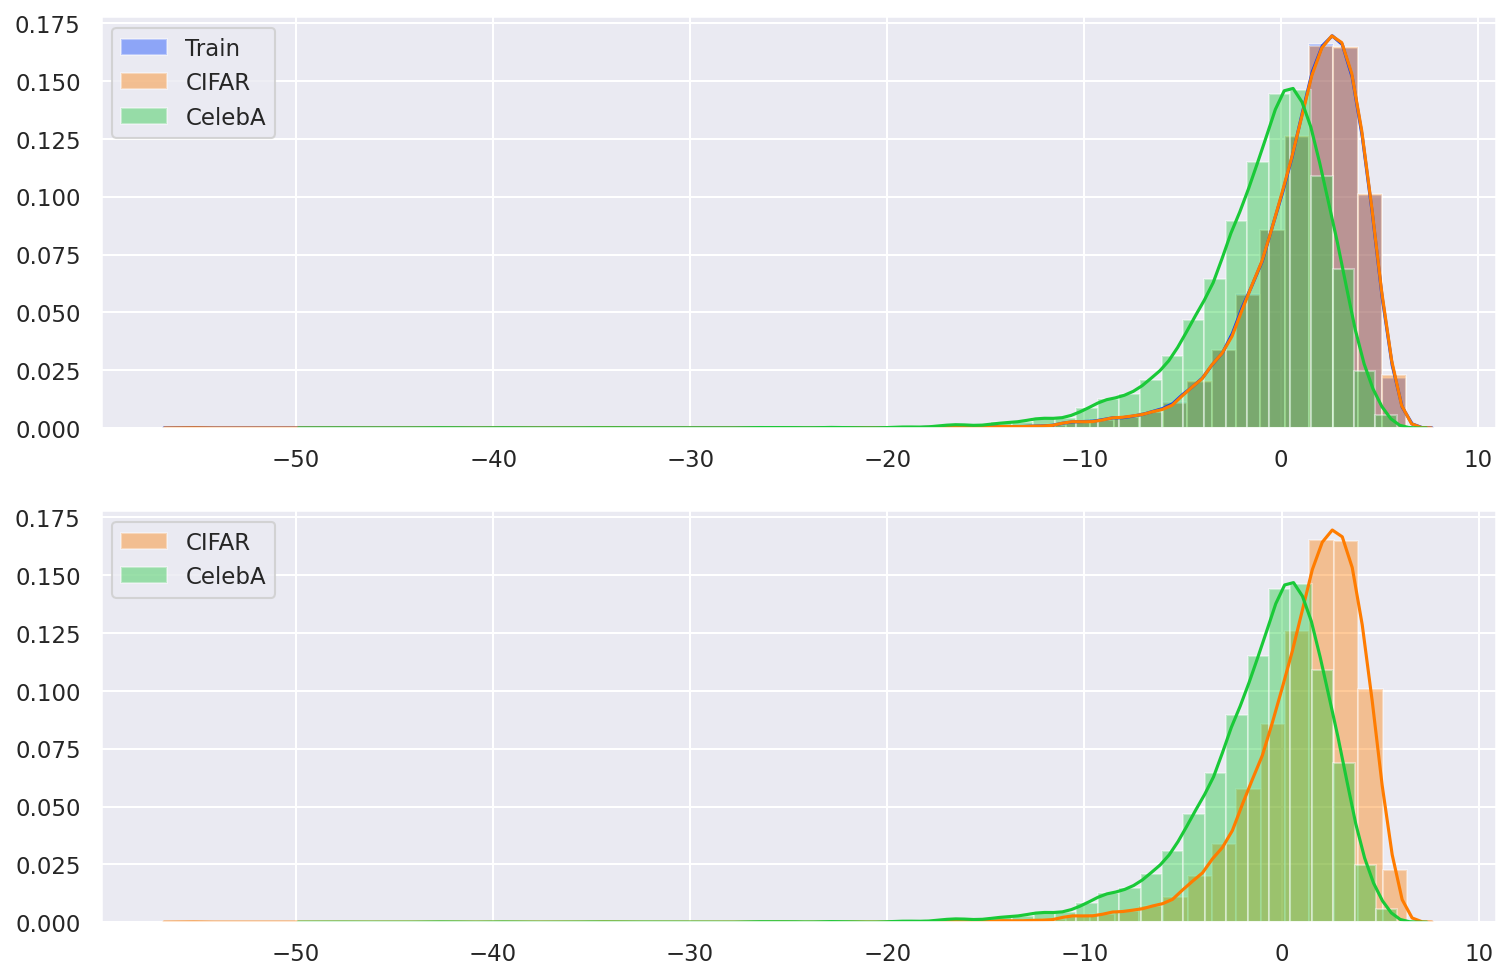

In [33]:
evaluate_model(train_score, test_score, ood_scores[0:1], labels=LABELS)

## Flow on CIFAR 10.1

In [296]:
# Density estimation with MADE.
n = cifar101_scores.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256, 256], activation="elu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.001),
              loss=lambda _, log_prob: -log_prob)

batch_size = 32
epochs = 10000
history = model.fit(
    x=cifar101_scores,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Epoch 1/10000
62/62 [==============================] - 0s 5ms/step - loss: 17389.5059
Epoch 2/10000
62/62 [==============================] - 0s 4ms/step - loss: 12344.9541
Epoch 3/10000
62/62 [==============================] - 0s 4ms/step - loss: 9882.5723
Epoch 4/10000
62/62 [==============================] - 0s 4ms/step - loss: 8330.2803
Epoch 5/10000
62/62 [==============================] - 0s 4ms/step - loss: 7272.9077
Epoch 6/10000
62/62 [==============================] - 0s 4ms/step - loss: 6428.7051
Epoch 7/10000
62/62 [==============================] - 0s 4ms/step - loss: 5830.8804
Epoch 8/10000
62/62 [==============================] - 0s 4ms/step - loss: 5296.5679
Epoch 9/10000
62/62 [==============================] - 0s 4ms/step - loss: 4889.8574
Epoch 10/10000
62/62 [==============================] - 0s 4ms/step - loss: 4528.6660
Epoch 11/10000
62/62 [==============================] - 0s 5ms/step - loss: 4244.2822
Epoch 12/10000
62/62 [==============================] - 0s 5m

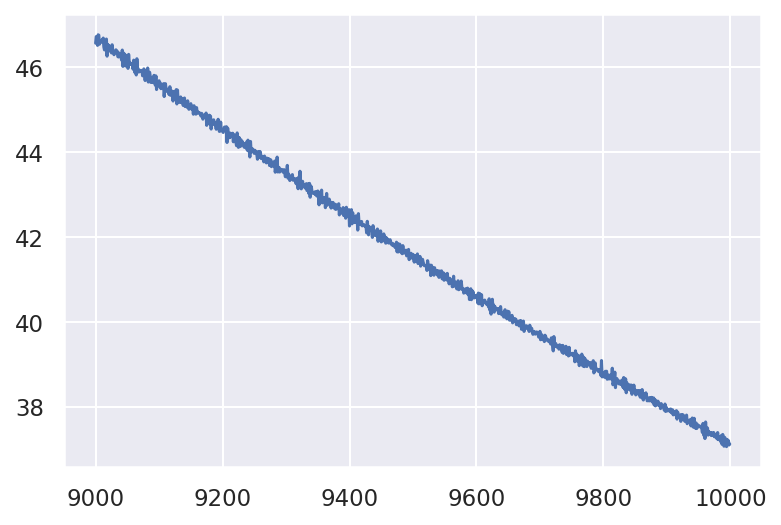

In [292]:
start_idx=9000
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

In [293]:
%%time
train_score = distribution.log_prob(cifar101_scores, dtype=np.float32).numpy()
test_score = distribution.log_prob(inlier_scores, dtype=np.float32).numpy()
ood_scores = [distribution.log_prob(ood, dtype=np.float32).numpy() for ood in outlier_scores]

CPU times: user 148 ms, sys: 24.4 ms, total: 172 ms
Wall time: 165 ms


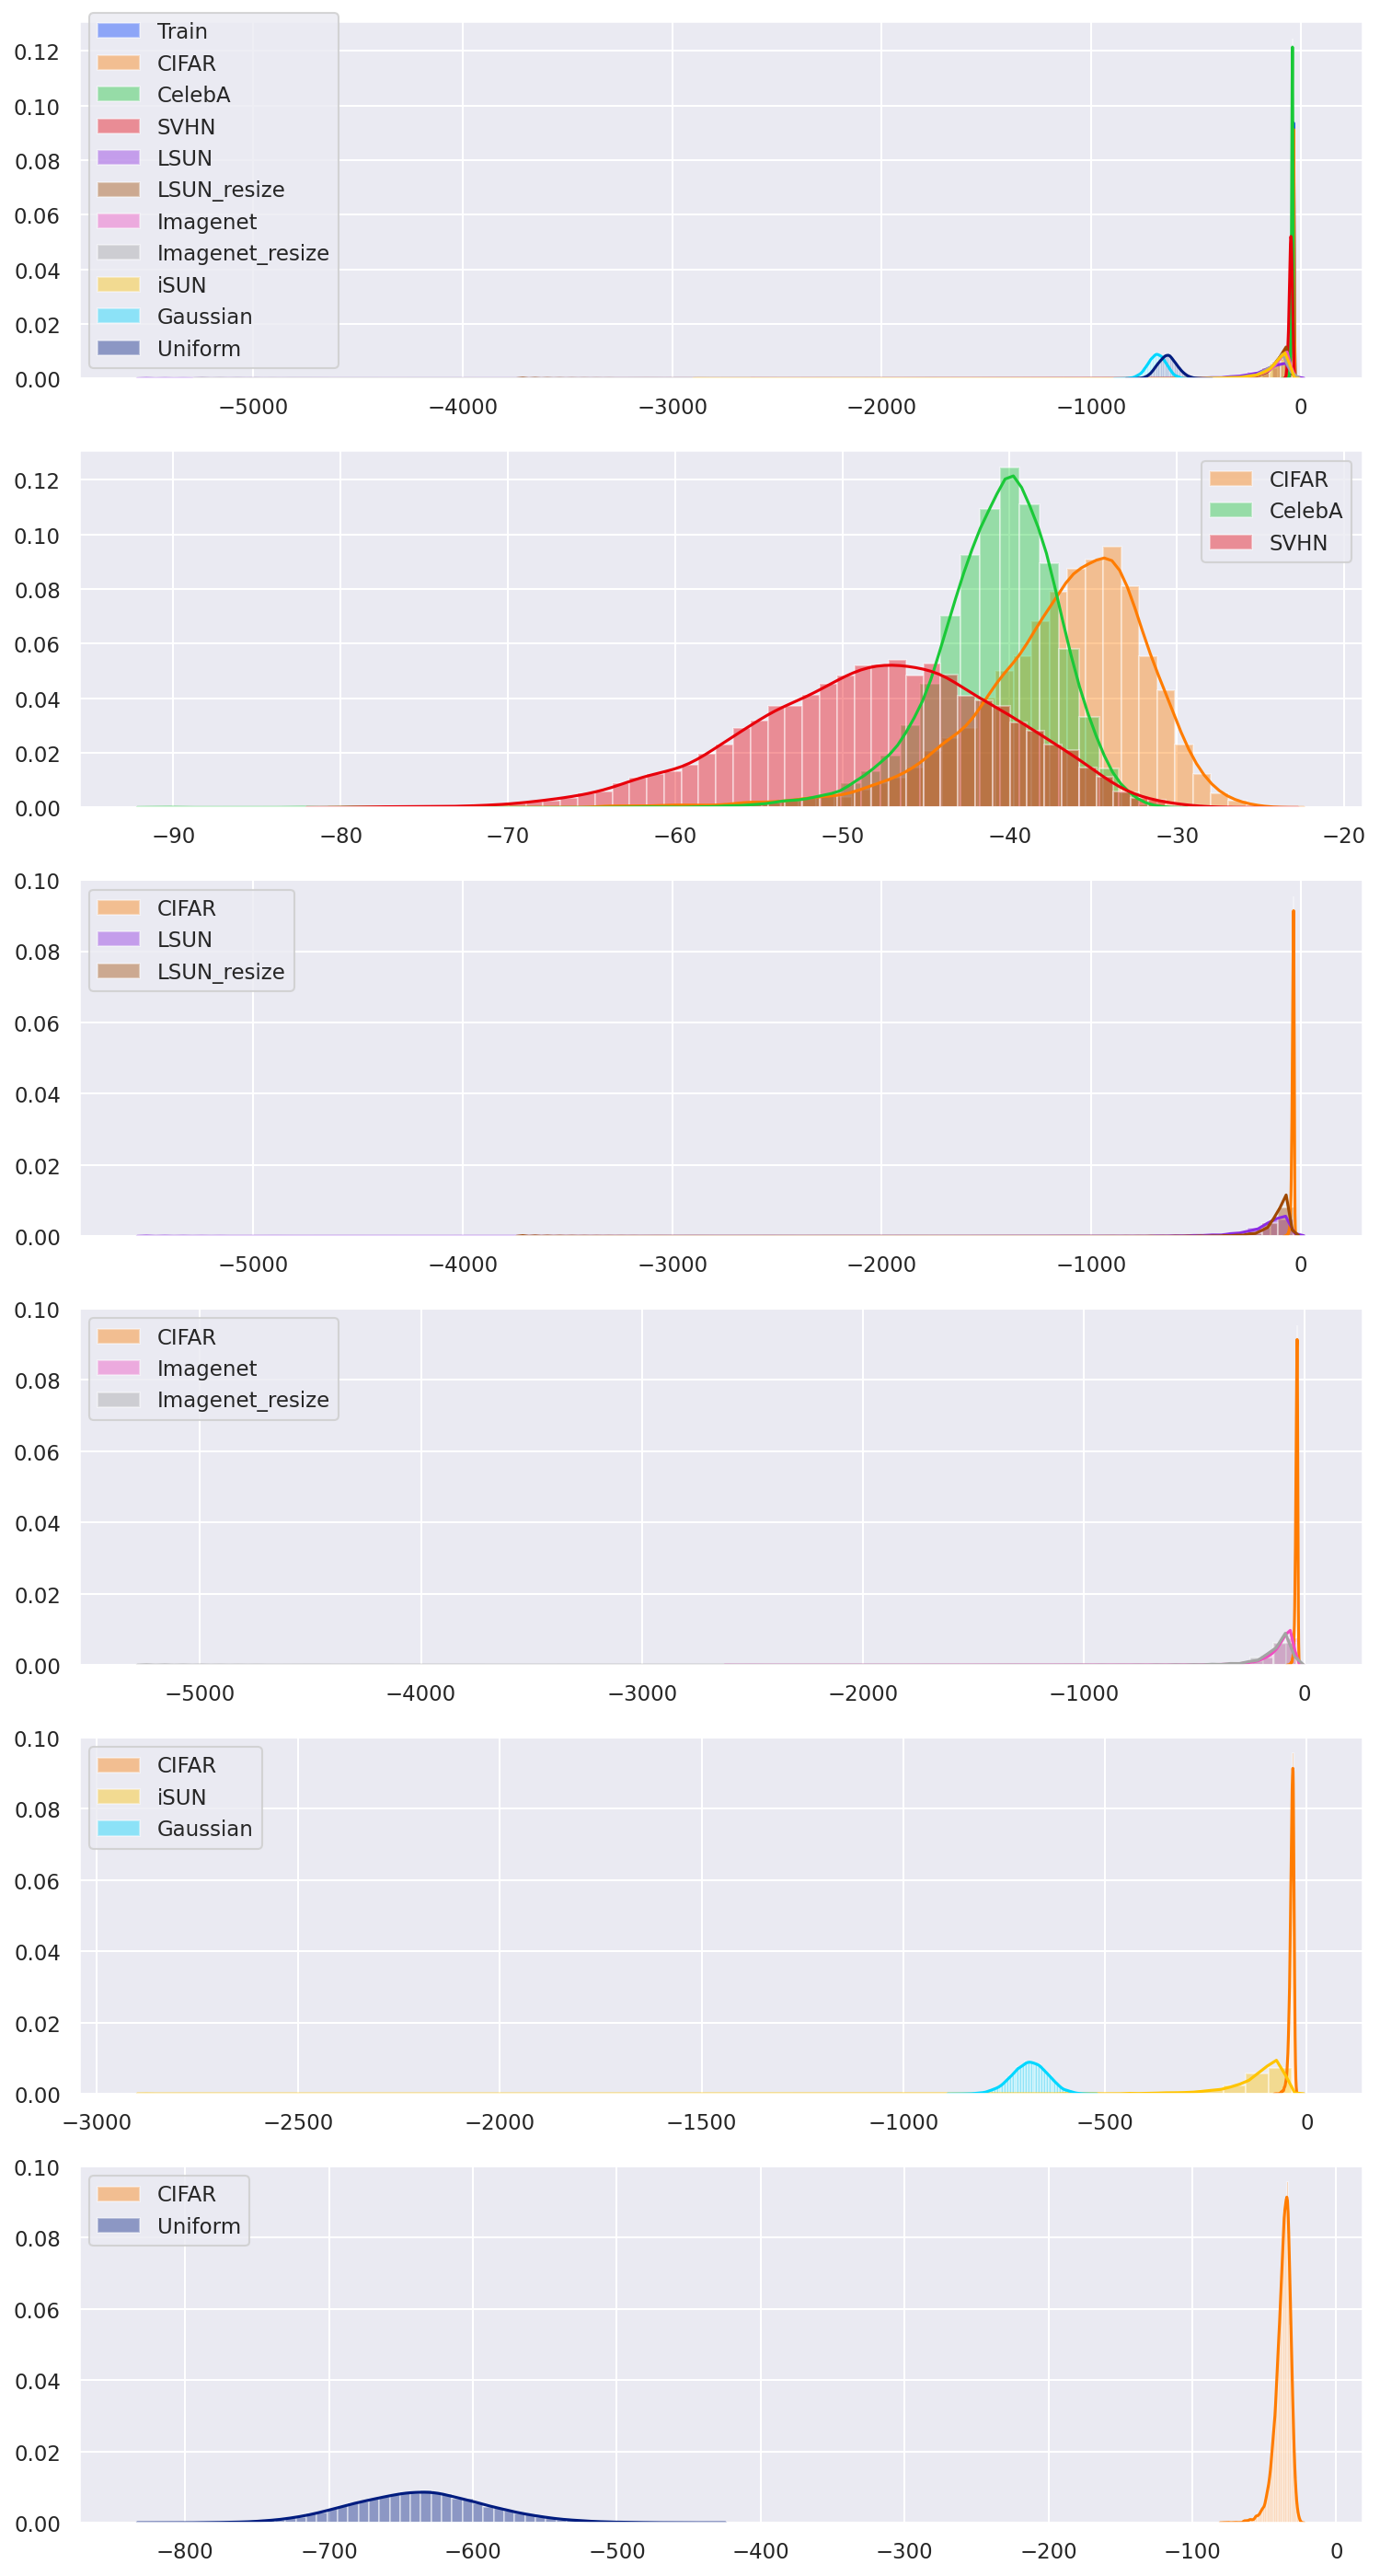

In [294]:
evaluate_model(train_score, test_score, ood_scores, labels=LABELS)

In [295]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.7534
PR-AUC (In/Out): 0.6563 / 0.8062
FPR (95% TPR) Prec: 0.5595

CIFAR vs SVHN
----------------
ROC-AUC: 0.8878
PR-AUC (In/Out): 0.8776 / 0.8818
FPR (95% TPR) Prec: 0.4860

CIFAR vs LSUN
----------------
ROC-AUC: 0.9950
PR-AUC (In/Out): 0.9957 / 0.9943
FPR (95% TPR) Prec: 0.0111

CIFAR vs LSUN_resize
----------------
ROC-AUC: 0.9966
PR-AUC (In/Out): 0.9968 / 0.9966
FPR (95% TPR) Prec: 0.0138

CIFAR vs Imagenet
----------------
ROC-AUC: 0.9949
PR-AUC (In/Out): 0.9954 / 0.9947
FPR (95% TPR) Prec: 0.0208

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 0.9984
PR-AUC (In/Out): 0.9985 / 0.9984
FPR (95% TPR) Prec: 0.0059

CIFAR vs iSUN
----------------
ROC-AUC: 0.9976
PR-AUC (In/Out): 0.9975 / 0.9979
FPR (95% TPR) Prec: 0.0100

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.000

In [ ]:
ood_metrics(-train_score, -test_score, names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

# UMAP

### Score Norms

In [87]:
samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

samples_train.shape

(27000, 10)

In [85]:
%%time
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=15,
                    min_dist=0.1)
reducer.fit(samples_train)

CPU times: user 59.2 s, sys: 1min 2s, total: 2min 2s
Wall time: 32 s


UMAP(n_components=3, random_state=42)

In [88]:
%%time
embedding = reducer.transform(samples_test)

CPU times: user 1.99 s, sys: 49.7 ms, total: 2.04 s
Wall time: 2.01 s


In [97]:
embedding.shape

(2962, 3)

In [96]:
[shapes[idx-1][0]-9000 for idx in range(1,4)]

[1000, 962, 1000]

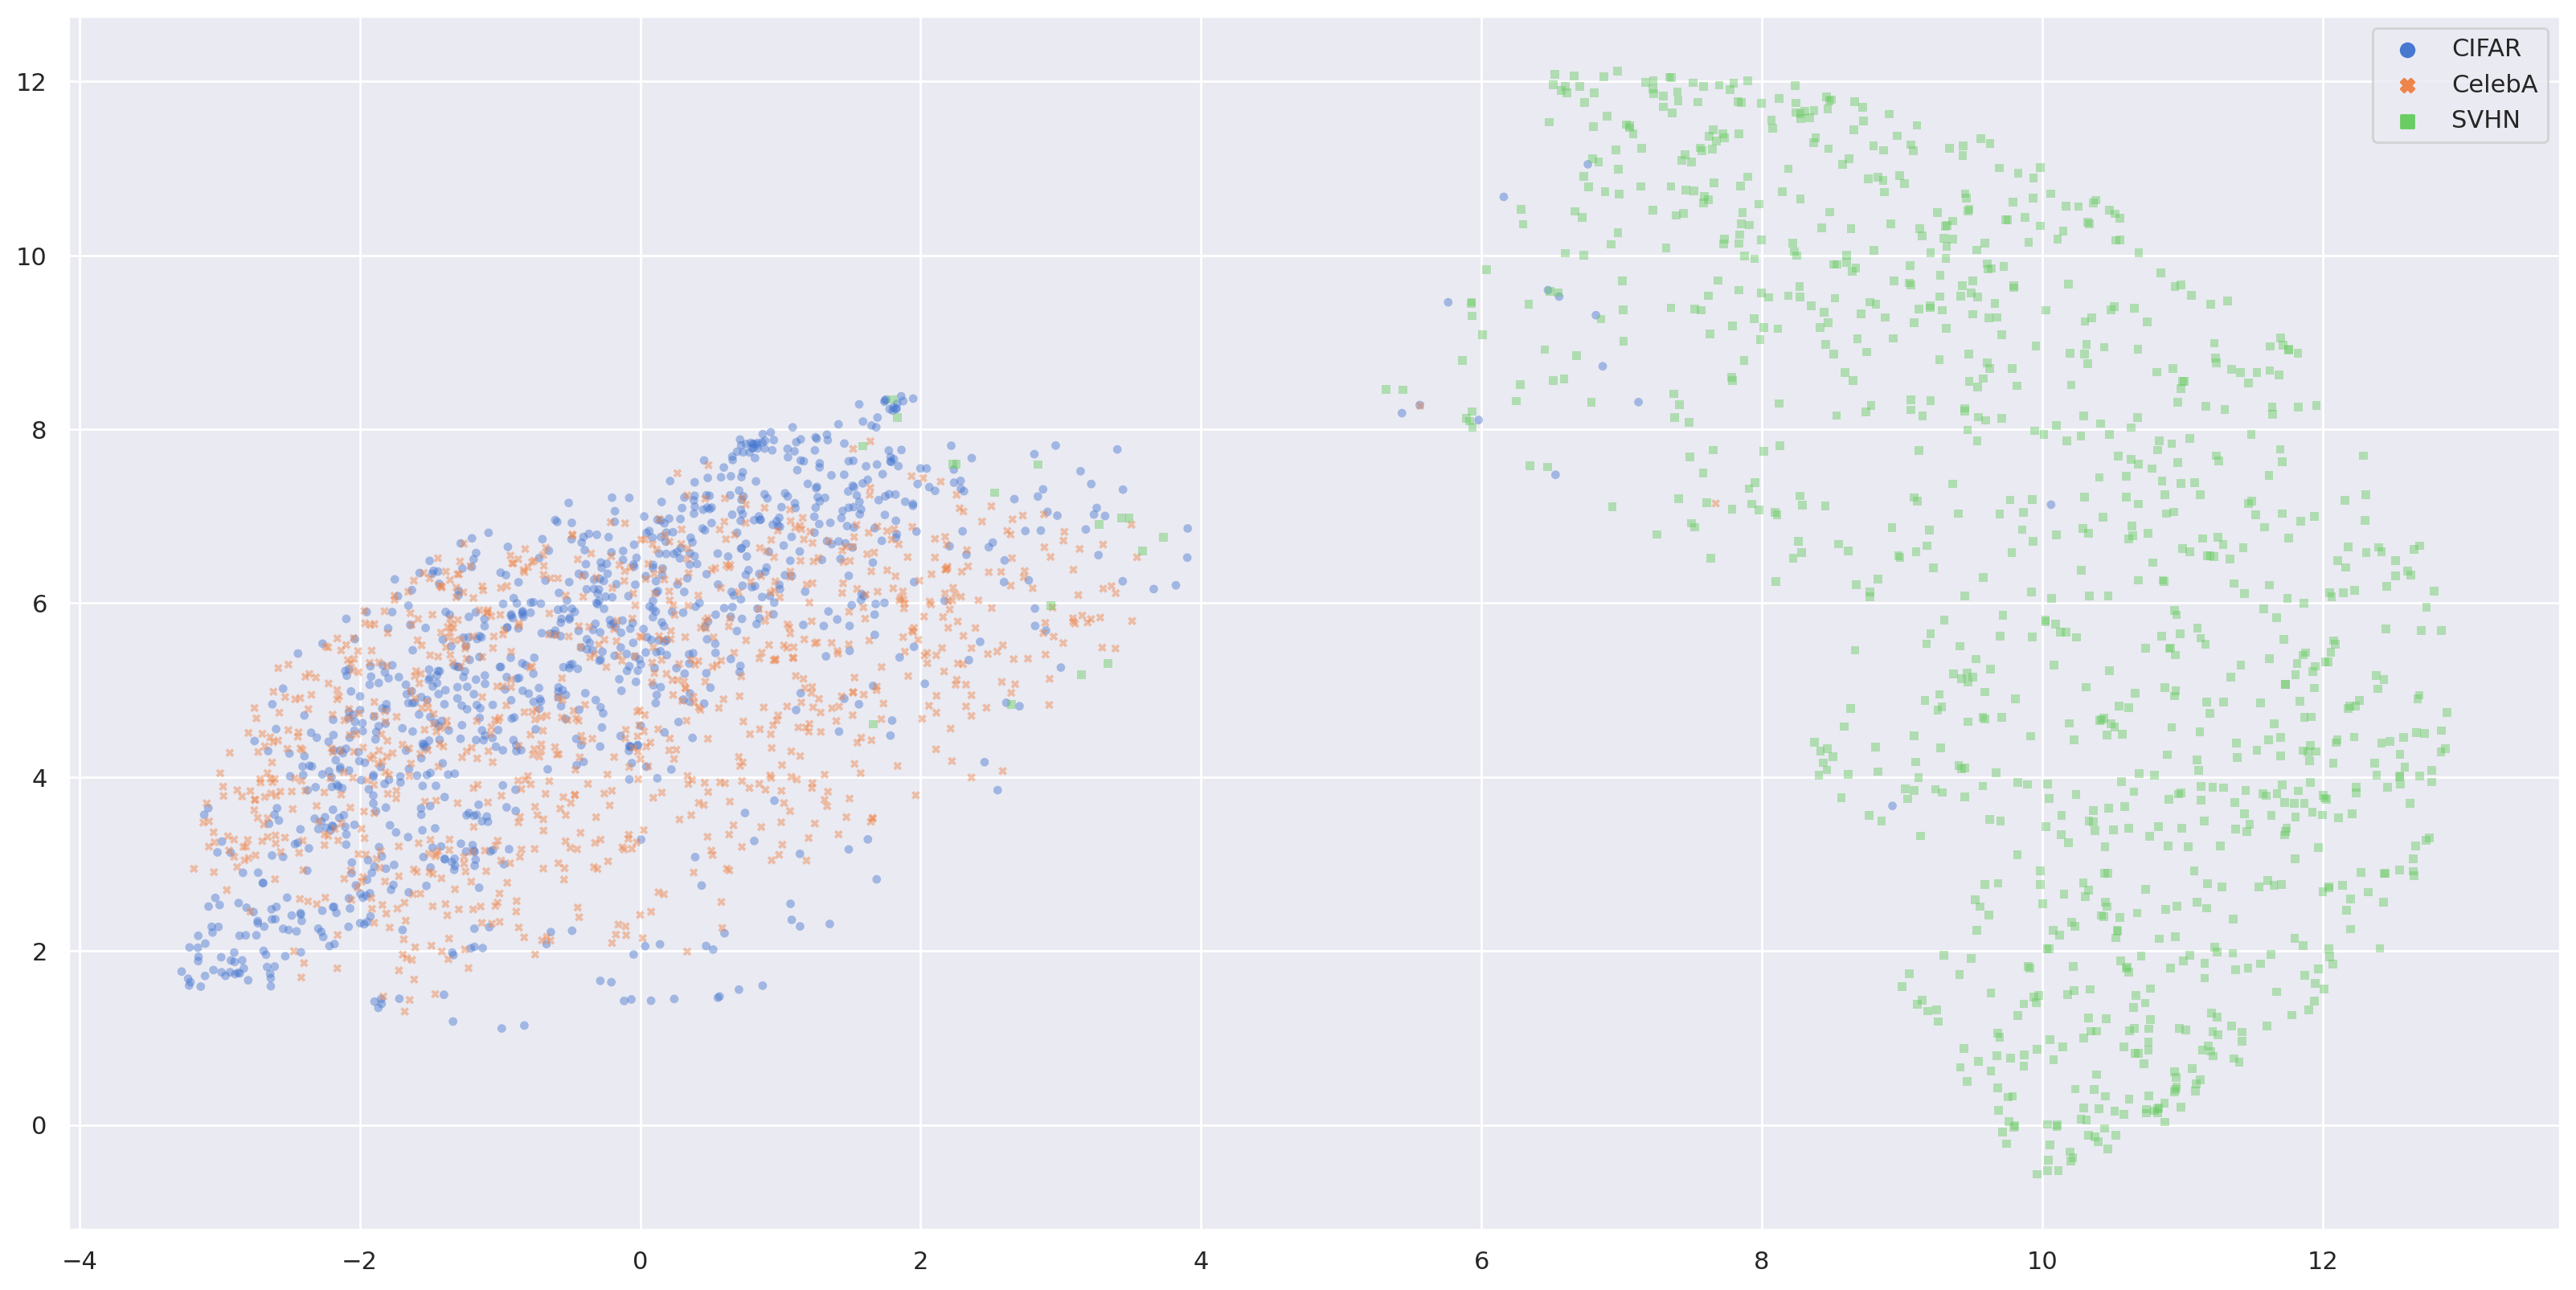

In [102]:
plt.figure(figsize=(20,10))

captions_test = np.concatenate([[LABELS[idx]]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
labels_test = np.concatenate([[idx]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
sns.scatterplot(x=embedding[:, 0],
                y=embedding[:, 1],
                hue=captions_test, style=captions_test, s=15, alpha=0.45, palette="muted", edgecolor="none")
plt.show()
# plt.close()

In [103]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Score Norms",
    marker=dict(
        size=2,
        color=labels_test,
        colorscale="Blackbody",
        opacity=0.5,
        showscale=True
    ),
    text=captions_test
)

layout = go.Layout(
    title="3D UMAP",
    autosize=False,
    width=1000,
    height=800,
#     paper_bgcolor='#F5F5F5',
#     template="plotly"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
fig.show("notebook")

## GMM on Embeddings

In [106]:
%%time
X_train_embedding = reducer.transform(X_train)
X_test_embedding = reducer.transform(X_test)
outlier_1_embedding = reducer.transform(outlier_data_1[9000:])
outlier_2_embedding = reducer.transform(outlier_data_2[9000:])

CPU times: user 9.6 s, sys: 340 ms, total: 9.94 s
Wall time: 9.82 s


In [155]:
outlier_train_embedding_1 = reducer.transform(outlier_data_1[:9000])
outlier_train_embedding_2 = reducer.transform(outlier_data_2[:9000])

In [107]:
X_train, X_test =  test_data[:9000], test_data[9000:]

In [131]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(20,101,10),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train_embedding)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   38.6s finished


CPU times: user 59.3 s, sys: 8.16 s, total: 1min 7s
Wall time: 43.4 s


Best: -2.327967 using {'GMM__covariance_type': 'full', 'GMM__n_components': 100}
---------------------------------------------------------------------------
-2.662801 (0.046925) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
-2.573499 (0.042412) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 30}
-2.506286 (0.047969) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 40}
-2.454949 (0.040034) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 50}
-2.428373 (0.039311) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 60}
-2.401051 (0.052309) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 70}
-2.368396 (0.039467) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 80}
-2.348367 (0.041998) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 90}
-2.327967 (0.038845) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 100}


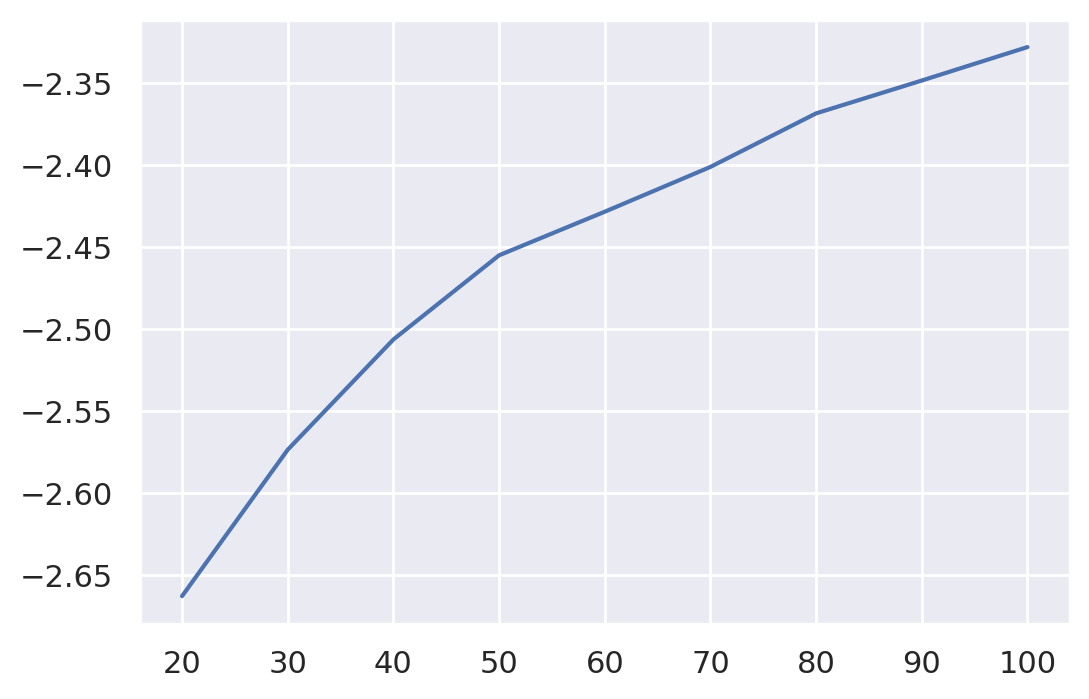

In [135]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [143]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': 20})

best_gmm_clf.fit(X_train_embedding)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_1_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_2_embedding)))

Training Likelihood: -2.651
CIFAR Likelihood: -2.703
CelebA Likelihood: -4.148
SVHN Likelihood: -21.181


In [ ]:
Training Likelihood: -2.535
CIFAR Likelihood: -2.615
CelebA Likelihood: -4.136
SVHN Likelihood: -21.257

In [144]:
train_score = best_gmm_clf.score_samples(X_train_embedding)
test_score = best_gmm_clf.score_samples(X_test_embedding)
outlier_score = best_gmm_clf.score_samples(outlier_1_embedding)
outlier_score_2 = best_gmm_clf.score_samples(outlier_2_embedding)

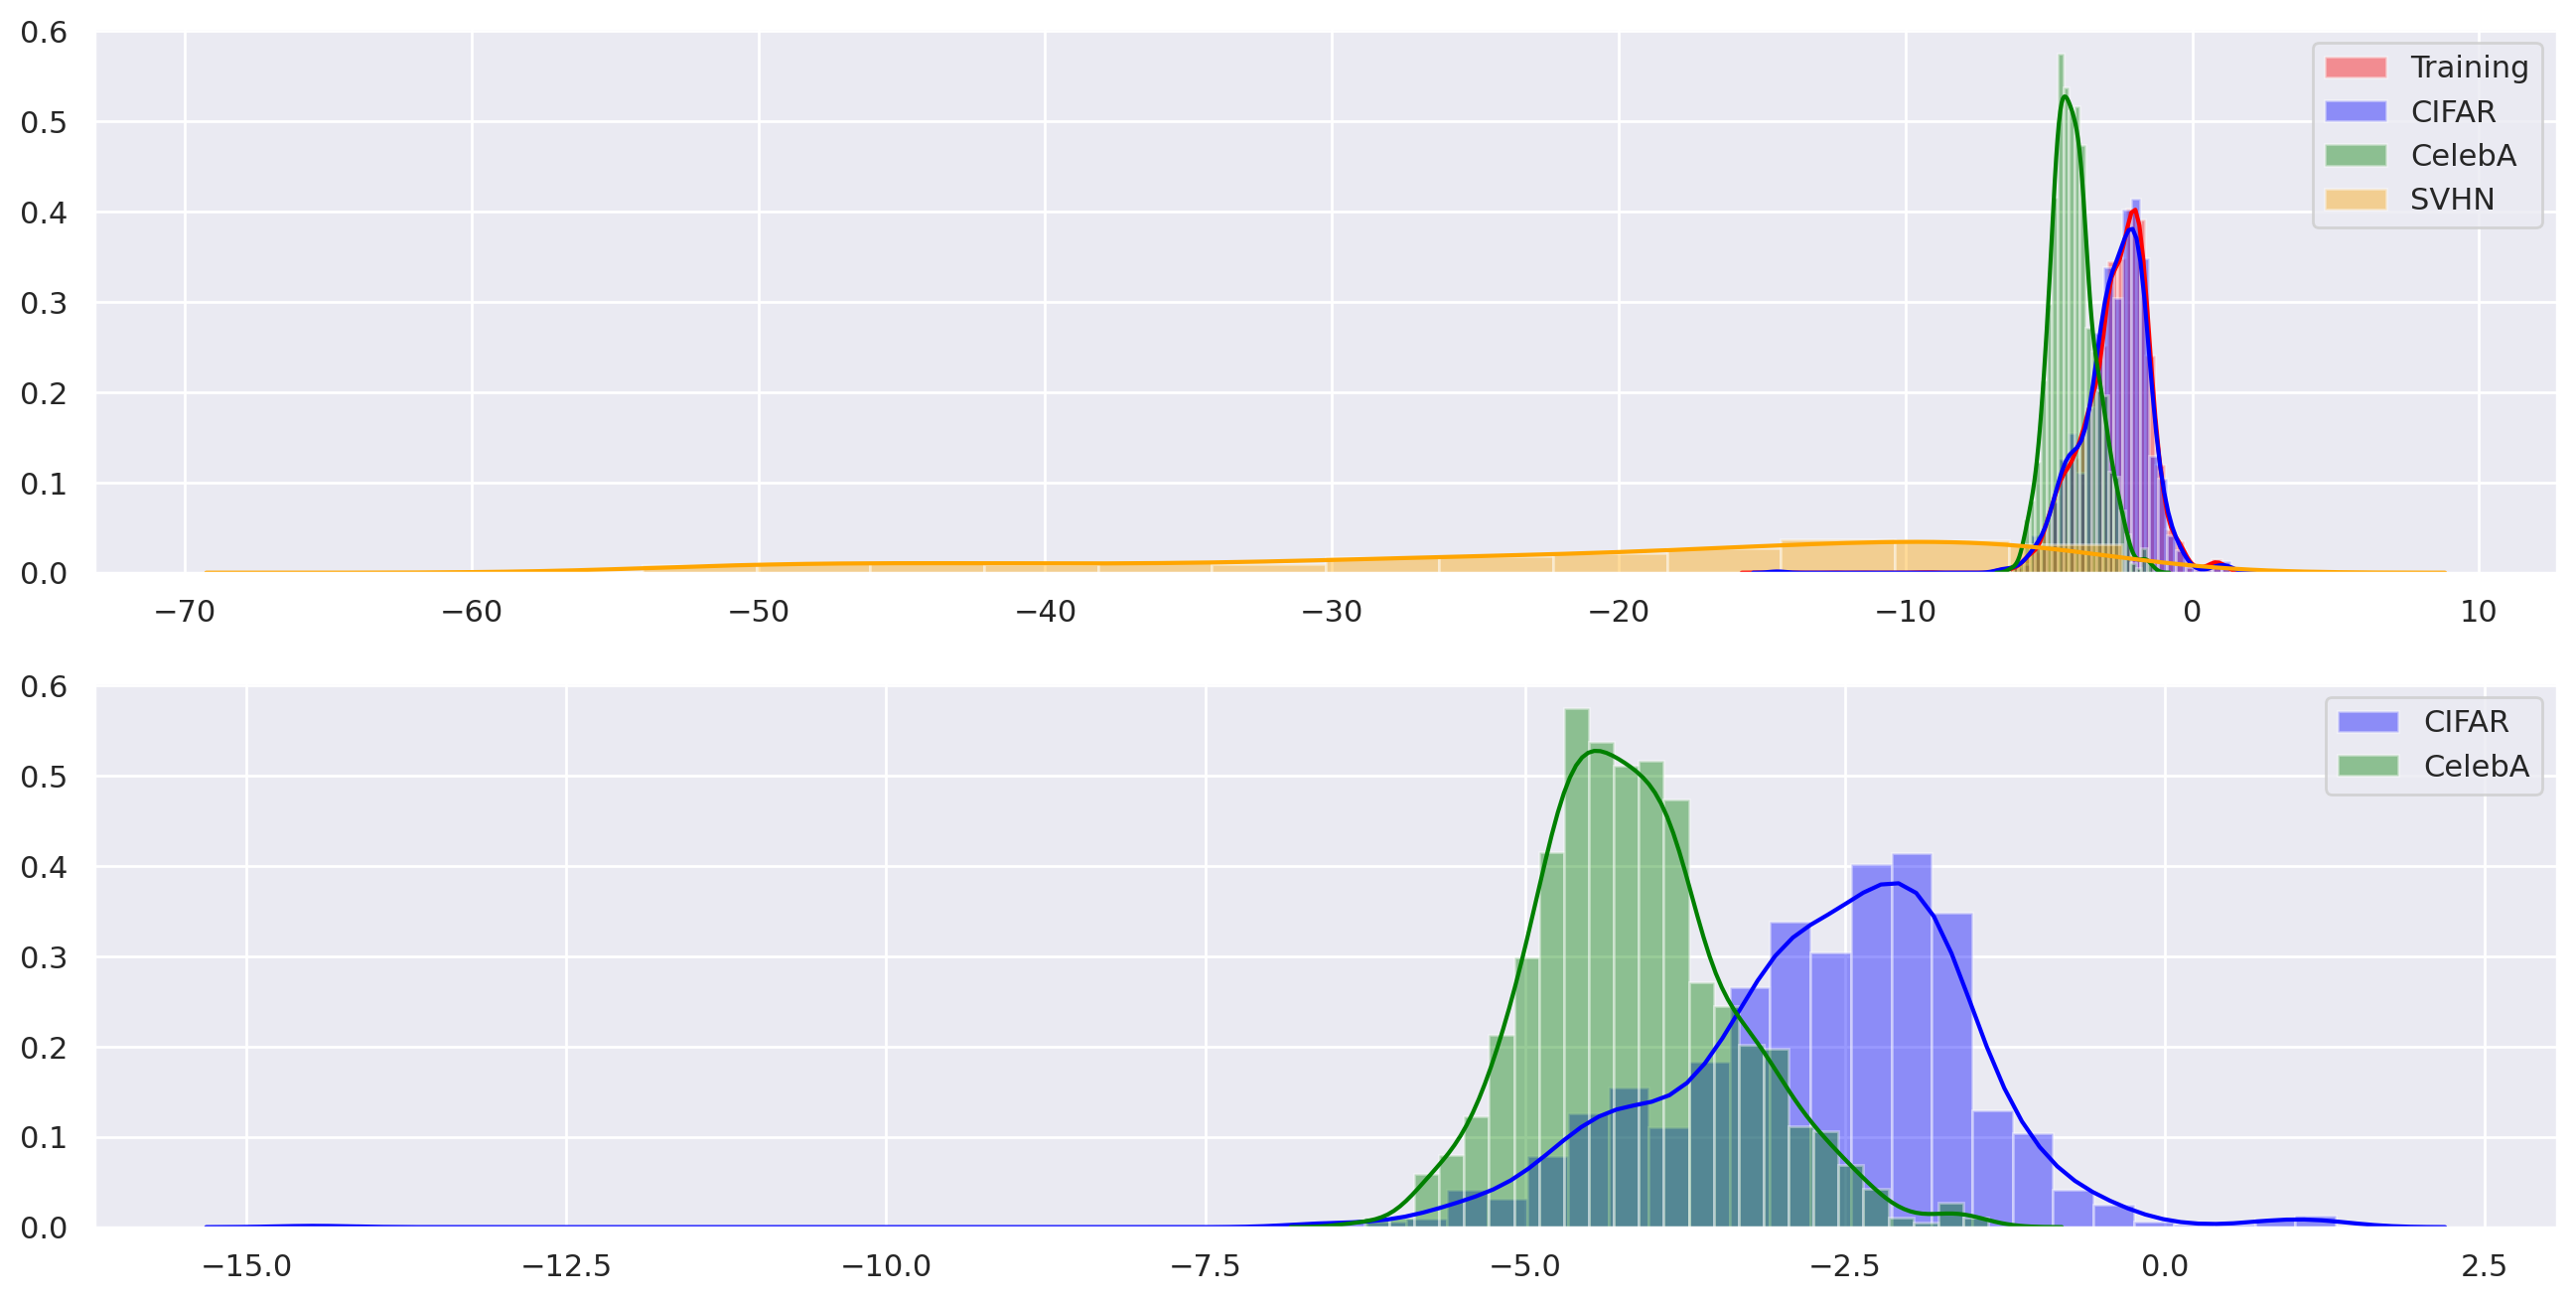

In [145]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_embedding_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [ ]:
%%time

max_n_component = 25
component_range = range(1, max_n_component+1, 1)

with ThreadPoolExecutor(max_workers = 6) as exc:
    result = list(exc.map(evaluate_GMM, component_range))
    
result = np.array(result)

In [166]:
plt.plot(component_range, result)

print("Best -> {}:{:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [ ]:
y_true = np.concatenate((np.zeros(len(inlier_score)),
                         np.ones(len(outlier_score))))
y_scores = np.concatenate((inlier_score, outlier_score))


roc_auc = roc_auc_score(y_true,y_scores)

In [151]:
metrics(-test_score, -np.concatenate((outlier_score, outlier_score_2)), plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9197
PR-AUC: 0.9564
Avg Prec: 0.9564


**CIFAR vs CelebA**

In [146]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8493
PR-AUC: 0.7716
Avg Prec: 0.7724


**CIFAR vs SVHN**

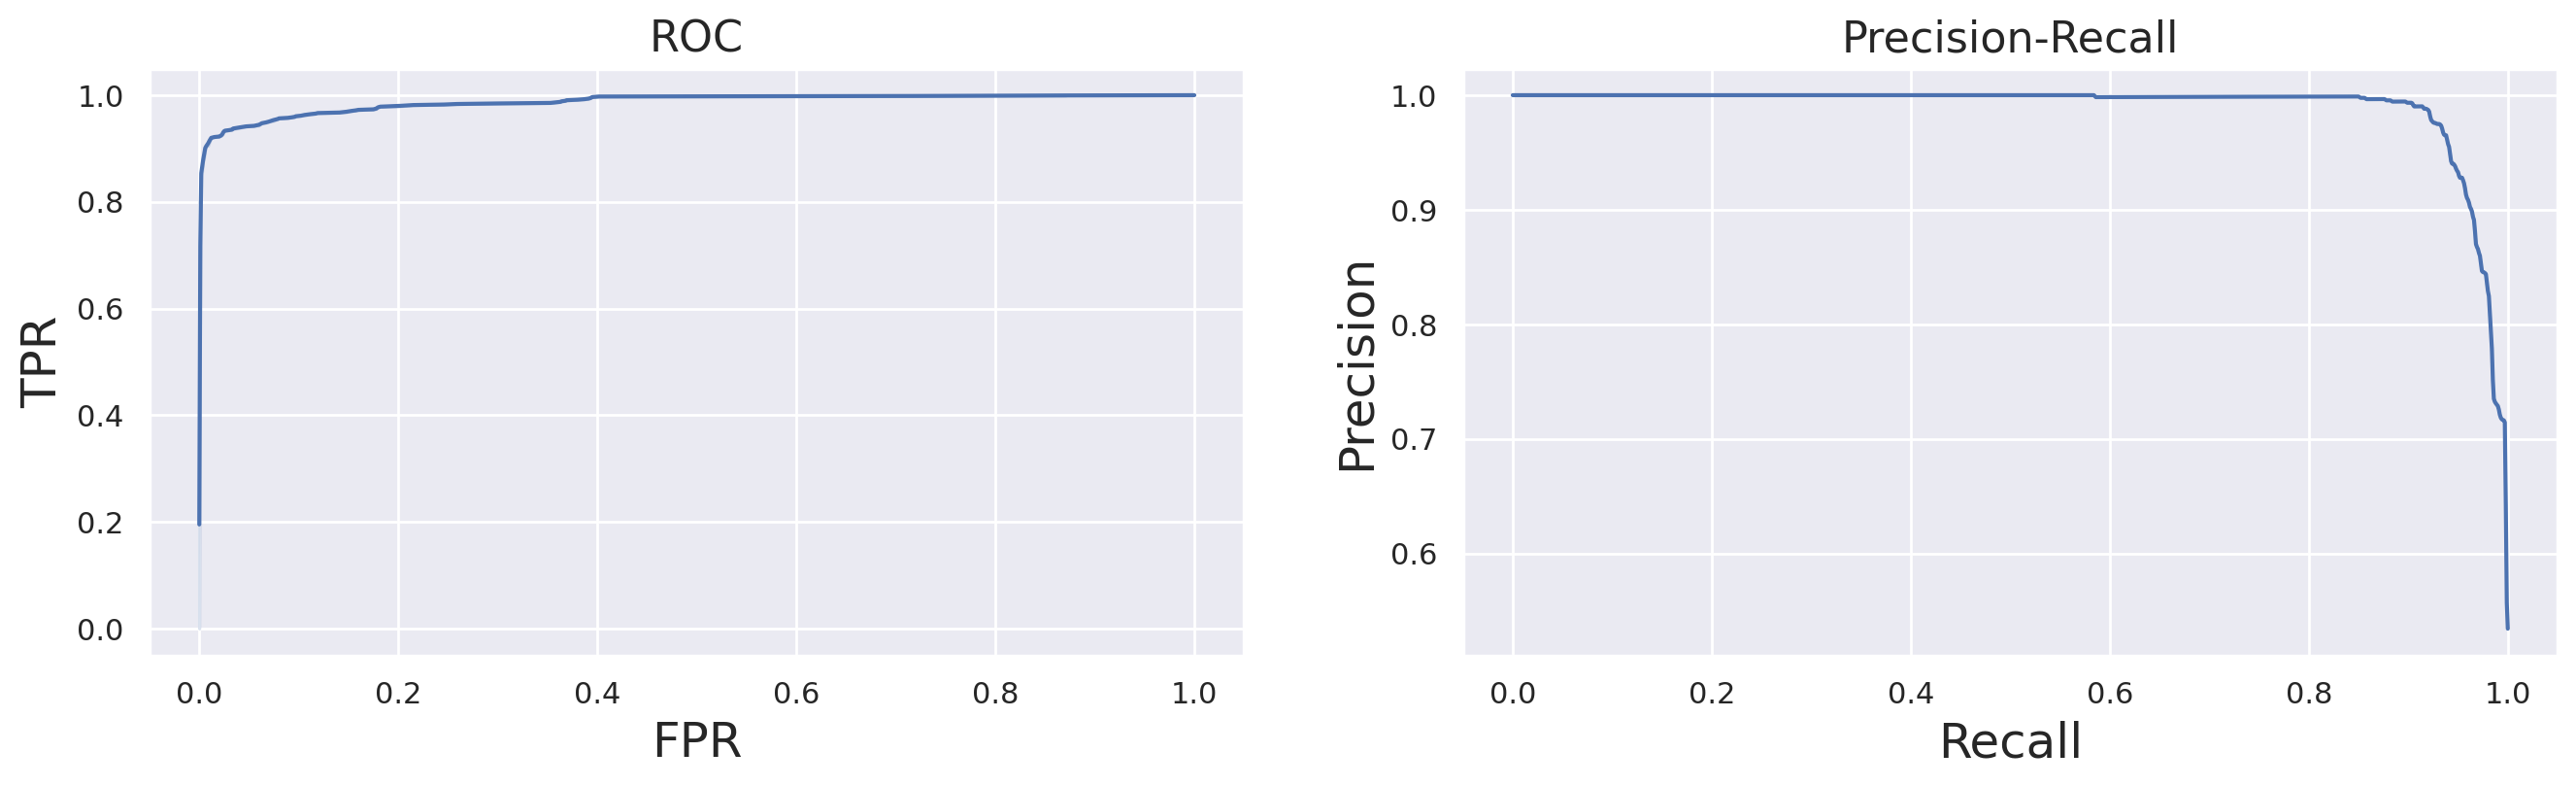

Inlier vs Outlier
----------------
ROC-AUC: 0.9868
PR-AUC: 0.9893
Avg Prec: 0.9893


In [119]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()